In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10", train=True, download=True, transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10", train=False, transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [6]:
train_dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


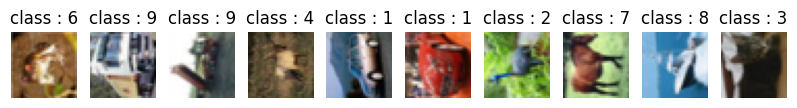

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+ 1)
    plt.axis('off')
    plt.imshow(np.transpose(train_dataset.data[i], (1,0,2)))
    plt.title("class : " + str(train_dataset.targets[i]))

In [16]:
# batch size 지정
BATCH_SIZE = 32
# suffle하는 이유 : sampling 의 편향을 막기 위해서 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [17]:
class DnnNet(nn.Module):
    def __init__(self):
        super(DnnNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 300)
        self.fc3 = nn.Linear(300, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x 

In [18]:
model = DnnNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for  batch_idx, (image, label)  in enumerate(train_loader):
        optimizer.zero_grad()
        preds = model(image)
        loss = loss_fn(preds, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [20]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for  image, label  in test_loader:
            preds = model(image)
            test_loss += loss_fn(preds, label).item()
            predictions = preds.max(1, keepdim=True)[1]
            correct += predictions.eq(label.view_as(predictions)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100 * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.294977
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.005986
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.811639
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.894136
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.767357
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.761021
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 2.021291
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.589145
Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.770817
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.763590
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.536573
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.553173
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.708253
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.550951
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.834916
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.776538
Train Epoch: 3 [0/50000 (0%)]	Train Loss: 1.656800
Train Epoch: 3 [6400/50000 (13%)]	Train Loss: 1.624077
Train Epoc

In [21]:
evaluate(model, test_loader)

(1.4819533273696899, 47.44)

In [22]:
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1   = nn.Linear(8 * 8 * 16, 64)
        self.fc2   = nn.Linear(64, 32)
        self.fc3   = nn.Linear(32, 10)

    def forward(self, x):
        # CNN
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        #DNN
        x = self.fc1(x.view(-1, 8 * 8 * 16))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)

        return x 

In [23]:
model_cnn = CnnNet()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model_cnn, train_loader, optimizer_cnn, log_interval=200)

/tmp/ipykernel_251/862021843.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.299479
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.101026
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.699848
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.537648
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.617142
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.526036
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.188474
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.564700
Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.396905
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.356552
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.443291
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.147833
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.307131
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.166103
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.371192
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.156117
Train Epoch: 3 [0/50000 (0%)]	Train Loss: 0.906090
Train Epoch: 3 [6400/50000 (13%)]	Train Loss: 1.593160
Train Epoc

In [24]:
pip install h5py

  Using cached h5py-3.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
Using cached h5py-3.12.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [32]:
import h5py
train_happy = h5py.File("./data/train_happy.h5", 'r')

In [33]:
train_happy['train_set_x']

<HDF5 dataset "train_set_x": shape (600, 64, 64, 3), type "|u1">

In [34]:
x_train = np.array(train_happy['train_set_x'][:])

In [35]:
y_train = np.array(train_happy['train_set_y'][:])

In [36]:
y_train[0]

np.int64(0)

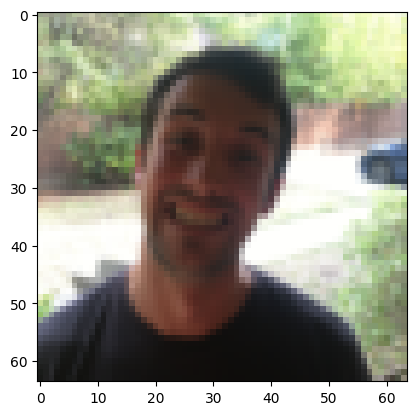

In [42]:
plt.imshow(x_train[5])0

In [43]:
y_train[5]

np.int64(1)

In [44]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([300, 300]))